### Computer Vision and Deep Learning, homework 2

Lev Svalov, l.svalov@innopolis.university <br>

**Reference**: code credit from [faster R-CNN tutorial](https://blog.roboflow.com/training-a-tensorflow-faster-r-cnn-object-detection-model-on-your-own-dataset/)

### 1. setup the model environment

In [ ]:
!pip install tensorflow_gpu==1.15

     |████████████████████████████████| 411.5 MB 8.4 kB/s 
     |████████████████████████████████| 50 kB 7.1 MB/s 
     |████████████████████████████████| 503 kB 43.3 MB/s 
     |████████████████████████████████| 3.8 MB 42.0 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=8dc732450fa62f844a7069cf52252db16a4da08d3754923375a1a4637e9cc383
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.7.0
    Uninstalling tensorflow-estimator-2.7.0:
      Successfully uninstalled tensorflow-estimator-2.7.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.7.0
    Uninstalling tensorboard-2.7.0:
      Successfully uninstalled tensorboard-2.7.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Succe

#### Configs and Hyperparameters


In [ ]:
repo_url = 'https://github.com/roboflow-ai/tensorflow-object-detection-faster-rcnn'

num_steps = 10000
num_eval_steps = 50

MODELS_CONFIG = {
    'faster_rcnn_inception_v2': {
        'model_name': 'faster_rcnn_inception_v2_coco_2018_01_28',
        'pipeline_file': 'faster_rcnn_inception_v2_pets.config',
        'batch_size': 6
    }
}


selected_model = 'faster_rcnn_inception_v2'
MODEL = MODELS_CONFIG[selected_model]['model_name']
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']
batch_size = MODELS_CONFIG[selected_model]['batch_size']

####  Clone the model repo

In [ ]:
import os

%cd /content

repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))

!git clone {repo_url}
%cd {repo_dir_path}
!git pull

/content
Cloning into 'tensorflow-object-detection-faster-rcnn'...
remote: Enumerating objects: 885, done.
remote: Total 885 (delta 0), reused 0 (delta 0), pack-reused 885
Receiving objects: 100% (885/885), 24.83 MiB | 25.28 MiB/s, done.
Resolving deltas: 100% (428/428), done.
/content/tensorflow-object-detection-faster-rcnn
Already up to date.


####  Install required dependencies

In [ ]:
%cd /content
!git clone --quiet https://github.com/tensorflow/models.git

!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib pycocotools tf_slim

%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.

import os
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'

!python object_detection/builders/model_builder_test.py

/content
Selecting previously unselected package python-bs4.
(Reading database ... 155222 files and directories currently installed.)
Preparing to unpack .../0-python-bs4_4.6.0-1_all.deb ...
Unpacking python-bs4 (4.6.0-1) ...
Selecting previously unselected package python-pkg-resources.
Preparing to unpack .../1-python-pkg-resources_39.0.1-2_all.deb ...
Unpacking python-pkg-resources (39.0.1-2) ...
Selecting previously unselected package python-chardet.
Preparing to unpack .../2-python-chardet_3.0.4-1_all.deb ...
Unpacking python-chardet (3.0.4-1) ...
Selecting previously unselected package python-six.
Preparing to unpack .../3-python-six_1.11.0-2_all.deb ...
Unpacking python-six (1.11.0-2) ...
Selecting previously unselected package python-webencodings.
Preparing to unpack .../4-python-webencodings_0.5-2_all.deb ...
Unpacking python-webencodings (0.5-2) ...
Selecting previously unselected package python-html5lib.
Preparing to unpack .../5-python-html5lib_0.999999999-1_all.deb ...
Unpa

### 2. Download my annotated dataset from Roboflow

In [ ]:
%cd /content/tensorflow-object-detection-faster-rcnn/data

/content/tensorflow-object-detection-faster-rcnn/data


In [ ]:
!curl -L https://app.roboflow.com/ds/BX5TYnx3AD?key=B1euIvRFc7 > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   891  100   891    0     0   1833      0 --:--:-- --:--:-- --:--:--  1833
100 2246k  100 2246k    0     0  3440k      0 --:--:-- --:--:-- --:--:--  114M
Archive:  roboflow.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
   creating: train/
 extracting: train/pears-lamps.tfrecord  
 extracting: train/pears-lamps_label_map.pbtxt  
   creating: valid/
 extracting: valid/pears-lamps.tfrecord  
 extracting: valid/pears-lamps_label_map.pbtxt  


In [ ]:
test_record_fname = '/content/tensorflow-object-detection-faster-rcnn/data/valid/pears-lamps.tfrecord'
train_record_fname = '/content/tensorflow-object-detection-faster-rcnn/data/train/pears-lamps.tfrecord'
label_map_pbtxt_fname = '/content/tensorflow-object-detection-faster-rcnn/data/train/pears-lamps_label_map.pbtxt'

### 3. Download base model

In [ ]:
%cd /content/models/research

import os
import shutil
import glob
import urllib.request
import tarfile
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = '/content/models/research/pretrained_model'

if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
    shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

/content/models/research


In [ ]:
fine_tune_checkpoint = os.path.join(DEST_DIR, "model.ckpt")
fine_tune_checkpoint

'/content/models/research/pretrained_model/model.ckpt'

### 4. Configuring a Training Pipeline

In [ ]:
import os
pipeline_fname = os.path.join('/content/models/research/object_detection/samples/configs/', pipeline_file)

assert os.path.isfile(pipeline_fname), '`{}` not exist'.format(pipeline_fname)

In [ ]:
def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())

In [ ]:
import re

num_classes = get_num_classes(label_map_pbtxt_fname)
with open(pipeline_fname) as f:
    s = f.read()
with open(pipeline_fname, 'w') as f:
    
    # fine_tune_checkpoint
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # tfrecord files train and test.
    s = re.sub(
        '(input_path: ".*?)(train.record)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(val.record)(.*?")', 'input_path: "{}"'.format(test_record_fname), s)

    # label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    f.write(s)

In [ ]:
!cat {pipeline_fname}

# Faster R-CNN with Inception v2, configured for Oxford-IIIT Pets Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

model {
  faster_rcnn {
    num_classes: 2
    image_resizer {
      keep_aspect_ratio_resizer {
        min_dimension: 600
        max_dimension: 1024
      }
    }
    feature_extractor {
      type: 'faster_rcnn_inception_v2'
      first_stage_features_stride: 16
    }
    first_stage_anchor_generator {
      grid_anchor_generator {
        scales: [0.25, 0.5, 1.0, 2.0]
        aspect_ratios: [0.5, 1.0, 2.0]
        height_stride: 16
        width_stride: 16
      }
    }
    first_stage_box_predictor_conv_hyperparams {
      op: CONV
      regularizer {
        l2_regularizer {
          weight: 0.0
        }
      }
      initializer {
        tru

In [ ]:
model_dir = 'training/'

In [ ]:
!pip install lvis

### 5. Train the model

In [ ]:
!python /content/models/research/object_detection/model_main.py \
    --pipeline_config_path={pipeline_fname} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --num_eval_steps={num_eval_steps}

Traceback (most recent call last):
  File "/content/models/research/object_detection/model_main.py", line 25, in <module>
    from object_detection import model_lib
  File "/content/models/research/object_detection/model_lib.py", line 29, in <module>
    from object_detection import eval_util
  File "/content/models/research/object_detection/eval_util.py", line 35, in <module>
    from object_detection.metrics import coco_evaluation
  File "/content/models/research/object_detection/metrics/coco_evaluation.py", line 25, in <module>
    from object_detection.metrics import coco_tools
  File "/content/models/research/object_detection/metrics/coco_tools.py", line 51, in <module>
    from pycocotools import coco
  File "/usr/local/lib/python3.7/dist-packages/pycocotools/coco.py", line 49, in <module>
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py", line 34, in <module>
    from matplotlib import rcsetup, style
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/st

In [ ]:
!ls {model_dir}

checkpoint
eval_0
events.out.tfevents.1638190874.9f8447bf2904
graph.pbtxt
model.ckpt-1643.data-00000-of-00001
model.ckpt-1643.index
model.ckpt-1643.meta
model.ckpt-2193.data-00000-of-00001
model.ckpt-2193.index
model.ckpt-2193.meta
model.ckpt-2740.data-00000-of-00001
model.ckpt-2740.index
model.ckpt-2740.meta
model.ckpt-3288.data-00000-of-00001
model.ckpt-3288.index
model.ckpt-3288.meta
model.ckpt-3839.data-00000-of-00001
model.ckpt-3839.index
model.ckpt-3839.meta


### 6. Get results of the model detection of objects

In [ ]:
import re
import numpy as np

output_directory = './fine_tuned_model'

lst = os.listdir(model_dir)
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join(model_dir, last_model)
print(last_model_path)
!python /content/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={pipeline_fname} \
    --output_directory={output_directory} \
    --trained_checkpoint_prefix={last_model_path}

training/model.ckpt-3839
Instructions for updating:
Please use `layer.__call__` method instead.
W1129 14:17:32.784965 140454462109568 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tf_slim/layers/layers.py:2802: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:Scale of 0 disables regularizer.
I1129 14:17:34.446217 140454462109568 regularizers.py:99] Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
I1129 14:17:34.614133 140454462109568 regularizers.py:99] Scale of 0 disables regularizer.
INFO:tensorflow:depth of additional conv before box predictor: 0
I1129 14:17:34.614668 140454462109568 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1129 14:17:34.699618 

In [ ]:
import os
import glob

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = pb_fname

# List of the strings that is used to add correct label for each box.
# PATH_TO_LABELS = label_map_pbtxt_fname
PATH_TO_LABELS = '/content/tensorflow-object-detection-faster-rcnn/data/test/pears-lamps_label_map.pbtxt'
TEST_IMAGE_PATHS = '/content/tensorflow-object-detection-faster-rcnn/data/valid/'
# If you want to test the code with your images, just add images files to the PATH_TO_TEST_IMAGES_DIR.
PATH_TO_TEST_IMAGES_DIR =  os.path.join(repo_dir_path, "data/valid")
print(PATH_TO_LABELS)
assert os.path.isfile(pb_fname)
assert os.path.isfile(PATH_TO_LABELS)
if len(TEST_IMAGE_PATHS) == 0:
  sample_img = 'https://storage.googleapis.com/roboflow-platform-transforms/Ly2DeBzbwsemGd2ReHk4BFxy8683/cf5ed147e4f2675fbabbc9b0db750ecf/transformed.jpg'
  import urllib.request
  urllib.request.urlretrieve(sample_img, 
                            PATH_TO_TEST_IMAGES_DIR + "/cell.jpg")

TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.*"))
assert len(TEST_IMAGE_PATHS) > 0, 'No image found in `{}`.'.format(PATH_TO_TEST_IMAGES_DIR)
print(TEST_IMAGE_PATHS)

/content/tensorflow-object-detection-faster-rcnn/data/test/pears-lamps_label_map.pbtxt
['/content/tensorflow-object-detection-faster-rcnn/data/valid/photo-1602096934132-ec3c50f55ec2_jpeg.rf.d617ab58a99e473e0c8340d4b5d3ae21.jpg', '/content/tensorflow-object-detection-faster-rcnn/data/valid/photo-1604591684189-86e88d006848_jpeg.rf.7d5db7f99767e39f57a27f4c50f3e4ef.jpg', '/content/tensorflow-object-detection-faster-rcnn/data/valid/photo-1544021770-7fe1de901890_jpeg.rf.f64ba5e192c626c4e47b17d09dbdf9b1.jpg', '/content/tensorflow-object-detection-faster-rcnn/data/valid/photo-1508345105453-e4abfea863c6_jpeg.rf.ee825ebad98d385495461682e3b83fa5.jpg', '/content/tensorflow-object-detection-faster-rcnn/data/valid/_annotations.coco.json', '/content/tensorflow-object-detection-faster-rcnn/data/valid/photo-1613925054466-df3b17123ca7_jpeg.rf.fcb44ac5e4236fbb746b9c67447d35ba.jpg', '/content/tensorflow-object-detection-faster-rcnn/data/valid/photo-1573675580577-58973eafd7ab_jpeg.rf.2ac00a1aa0f7c271f0af56

In [ ]:
%cd /content/models/research/object_detection

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops


# This is needed to display the images.
%matplotlib inline


from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util

/content/models/research/object_detection


In [ ]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

In [ ]:
%matplotlib inline

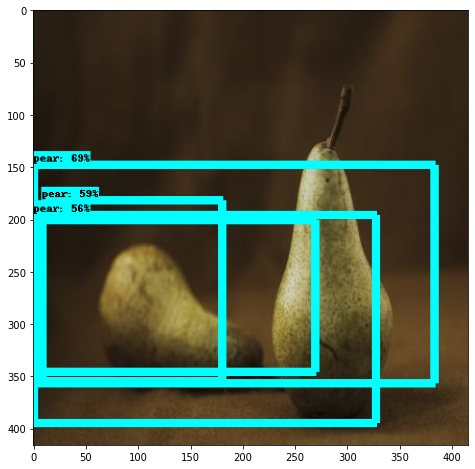

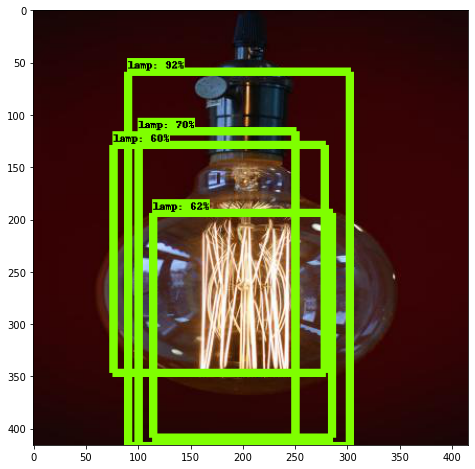

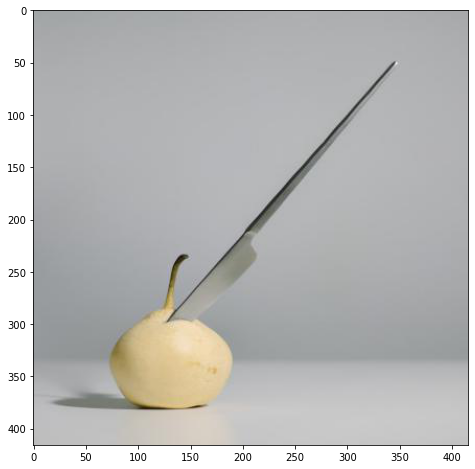

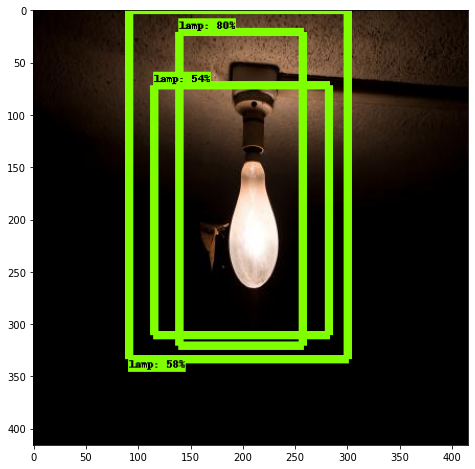

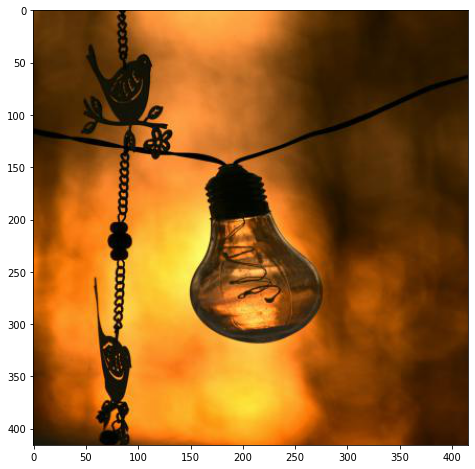

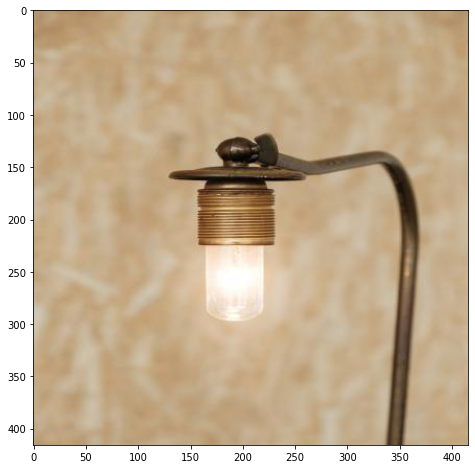

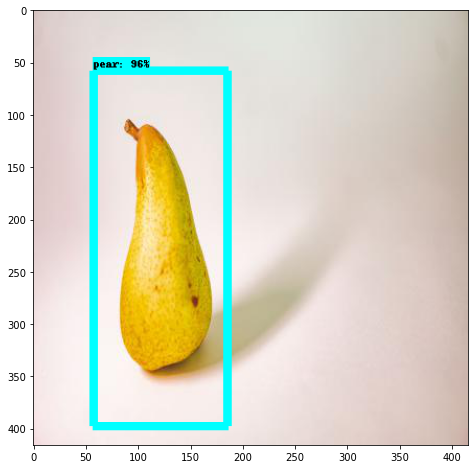

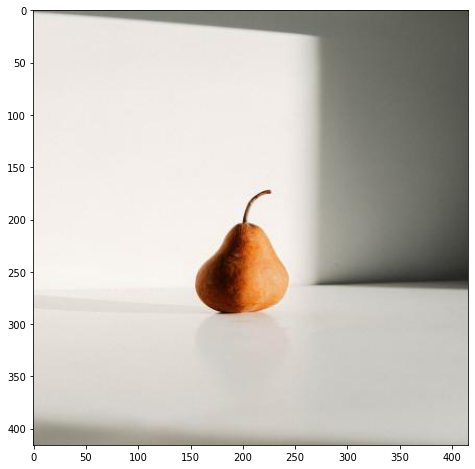

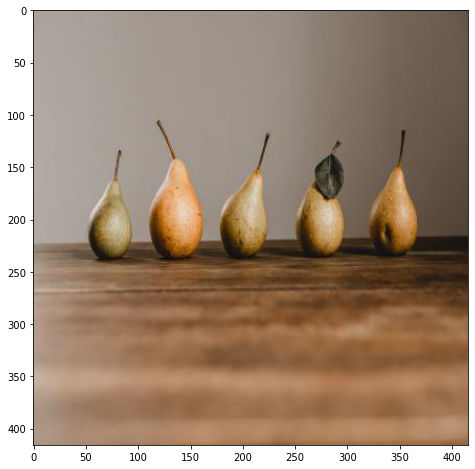

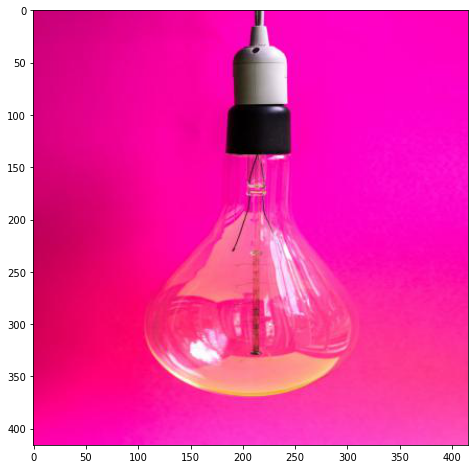

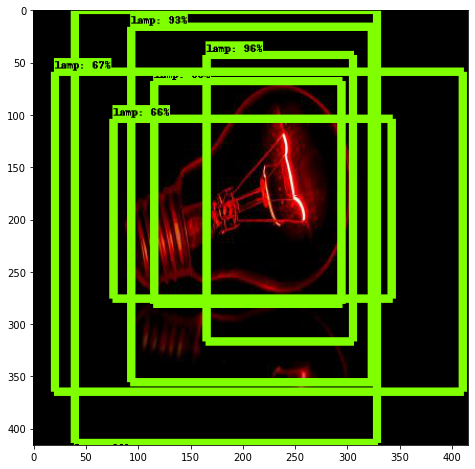

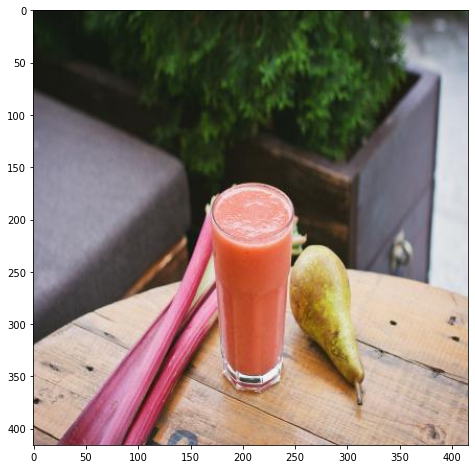

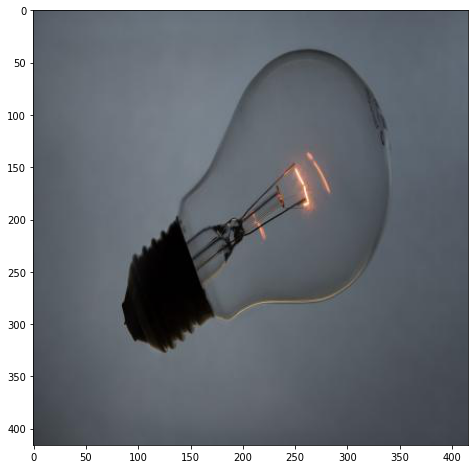

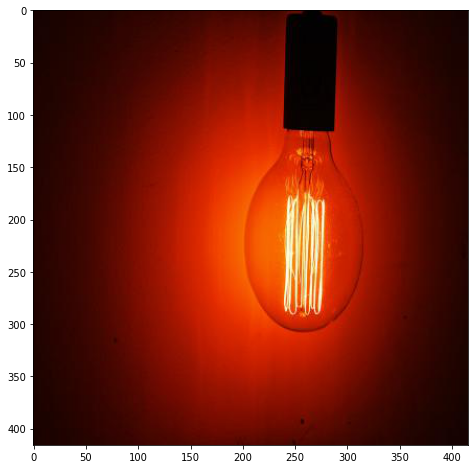

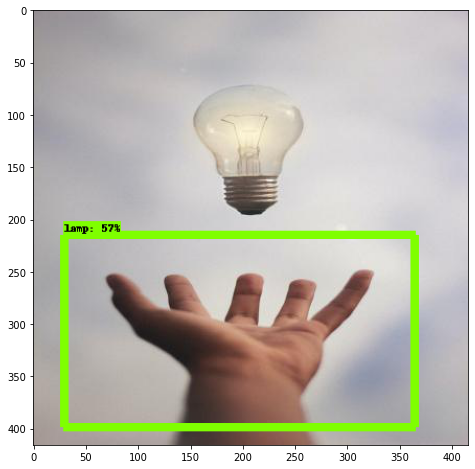

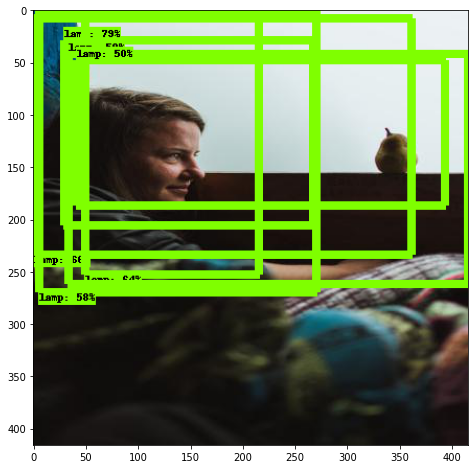

In [ ]:
for image_path in TEST_IMAGE_PATHS:
    if image_path == '/content/tensorflow-object-detection-faster-rcnn/data/valid/_annotations.coco.json':
      continue
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)